# N body problem

According to Newton's law a force of attraction between body $i$ and $j$ can be expressed as

$$
\mathbf{F}_{ij}
    = \frac{G m_i m_j}{\left\| \mathbf{r}_j - \mathbf{r}_i\right\| ^ 2} \frac{\left(\mathbf{r}_j - \mathbf{r}_i\right)}{\left\| \mathbf{r}_j - \mathbf{r}_i\right\|}
$$

Resultant force acting on $i$ can be found when summing over all the interactions with $N-1$ bodies 

$$
\mathbf{F}_{i}
    =  \sum_{j=1 \atop j \ne i}^N \frac{G m_i m_j }{\left\| \mathbf{r}_j - \mathbf{r}_i\right\|^2} \frac{\left(\mathbf{r}_j - \mathbf{r}_i\right)}{\left\| \mathbf{r}_j - \mathbf{r}_i\right\|}
$$

or in explicit differential form

$$
\frac{d^2\mathbf{r}_i}{dt^2}
    =  \sum_{j=1 \atop j \ne i}^N \frac{G m_j }{\left\| \mathbf{r}_j - \mathbf{r}_i\right\|^2} \frac{\left(\mathbf{r}_j - \mathbf{r}_i\right)}{\left\| \mathbf{r}_j - \mathbf{r}_i\right\|}
$$




In [125]:
import numpy as np
from scipy.integrate import odeint
from typing import List, Dict, Tuple, Self
from itertools import combinations, chain
from matplotlib import pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation

G = 1

In [126]:
class Body:
    def __init__(
        self,
        m : float,
        r_0 : Tuple[float, float], 
        v_0 : Tuple[float, float],
        name: str = "body"
    ) -> None:
        self.m = m
        self.r_0 = r_0
        self.x_0 = r_0[0]
        self.y_0 = r_0[1]
        self.v_0 = v_0
        self.vx_0 = v_0[0]
        self.vy_0 = v_0[1]
        self.name = name

    def distance(self, body: Self) -> float:
        return np.sqrt((self.x_0 - body.x_0) ** 2 + (self.y_0 - body.y_0) ** 2)

earth = Body(
    m = 1, 
    r_0 = (1, 0), 
    v_0 = (0, np.sqrt(333000)),
    name = "earth"
)
sun = Body(
    m = 333000, 
    r_0 = (0, 0),
    v_0 = (0, 0),
    name = "sun"
)
pp = Body(
    m = 100000,
    r_0 = (1, 2),
    v_0 = (0, 0),
    name = "pp"
)

r_sun_earth = sun.distance(earth)
r_sun_earth

1.0

In [136]:
class System:
    def __init__(self, *bodies: Body) -> None:
        self.bodies = bodies
        self.bodies_dict = {body.name : body for body in bodies}
        self.interactions = self.calculate_interactions()

    def prepare_initial_data(self):
        positions = [[body.x_0, body.y_0] for body in self.bodies]
        velocities = [body.v_0 for body in self.bodies]
        accelerations = [[self.interactions[body]['a_x'], self.interactions[body]['a_y']] for body in self.bodies_dict]
        
        s_0 = list(chain(*positions+velocities))
        dsdt =  list(chain(*velocities + accelerations))
        return {"s_0" : s_0, "dsdt": dsdt}
   
    def get_all_unique_bodies_combinations(self):
        return list(combinations(self.bodies, 2))
    
    def calculate_interactions(self):
        epsilon_space = 1e-9
        accs = {body.name: {'a_x': 0, 'a_y': 0} for body in self.bodies}

        for body1, body2 in self.get_all_unique_bodies_combinations():
            r_x = body2.x_0 - body1.x_0
            r_y = body2.y_0 - body1.y_0
            distance = body1.distance(body2)
            if distance - epsilon_space < 0:
                continue

            accs[body1.name]['a_x'] += body2.m * r_x / distance ** 3
            accs[body1.name]['a_y'] += body2.m * r_y / distance ** 3
            accs[body2.name]['a_x'] -= body1.m * r_x / distance ** 3
            accs[body2.name]['a_y'] -= body1.m * r_y / distance ** 3

        return accs
    
    def _plot_system(self):
        for body_name, body in self.bodies_dict.items():
            plt.scatter(body.x_0, body.y_0, label = body_name)
        
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.show()

    def derivatives(self, s, t):
        num_bodies = len(self.bodies)
        positions = np.reshape(s[:2 * num_bodies], (num_bodies, 2))
        velocities = np.reshape(s[2 * num_bodies:], (num_bodies, 2))
        accelerations = np.zeros_like(positions)

        for i, body1 in enumerate(self.bodies):
            for j, body2 in enumerate(self.bodies):
                if i != j:
                    r = positions[j] - positions[i]
                    distance = np.sqrt(np.dot(r, r))
                    if distance < 0.000001:
                        continue  # Avoid division by zero
                    acc = body2.m * r / distance**3
                    accelerations[i] += acc

        dsdt = np.concatenate((velocities, accelerations)).flatten()
        return dsdt

    def solve(self, t):
        initial_data = self.prepare_initial_data()
        s_0 = initial_data["s_0"]
        solution = odeint(self.derivatives, s_0, t)
        return solution
   
# test           
s = System(earth, sun, pp)
s.bodies

s.bodies_dict

{'earth': <__main__.Body at 0x7f0414667050>,
 'sun': <__main__.Body at 0x7f04146509d0>,
 'pp': <__main__.Body at 0x7f041607fad0>}

In [140]:
t = np.linspace(0, 1, 10000)
sol = s.solve(t)

x1 = sol.T[0]
y1 = sol.T[1]
x2 = sol.T[2]
y2 = sol.T[3]
x3 = sol.T[4]
y3 = sol.T[5]

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5643987051993D-02   r2 =  0.3646383510005D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5643987051993D-02   r2 =  0.1458553404002D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5643987051993D-02   r2 =  0.2917106808004D-18
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.5643987051993D-02   r2 =  0.2917106808004D-18
 lsoda--  warning..internal t (=r1) 

/usr/lib/python3/dist-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


IndexError: list index out of range

Error in callback <function _draw_all_if_interactive at 0x7f041d91f100> (for post_execute):


ValueError: too many values to unpack (expected 2)

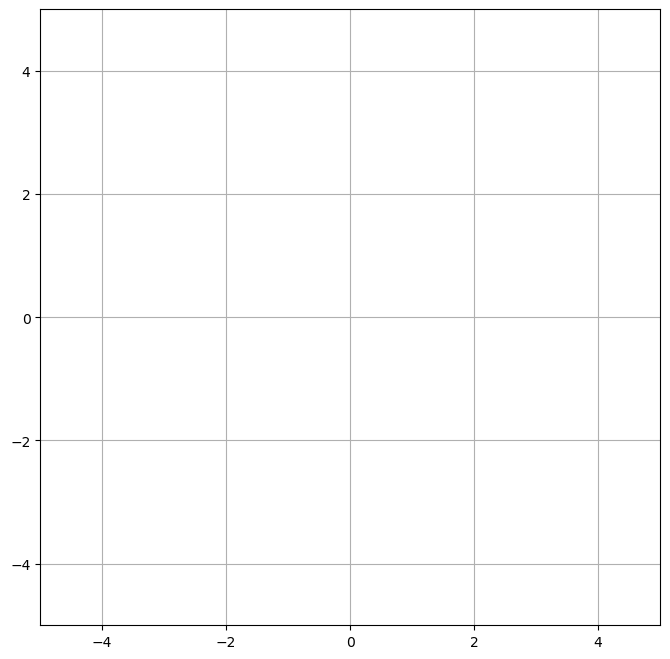

In [145]:
# 1) Convert to seconds (SI unit) using equation above
tt = 1/np.sqrt(6.67e-11 * 5.97e24 / (1.5e11)**3 ) 
# 2) Convert from seconds to years
tt = tt / (60*60 * 24* 365.25) * np.diff(t)[0] # per time step (in years)

def animate(i):
    ln1.set_data([x1[i], x2[i]], [y1[i], y2[i]], [y3[i], y3[i]])
    text.set_text('Time = {:.2f} Years'.format(i*tt))
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.grid()
ax.set_ylim(-5, 5)
ax.set_xlim(-5,5)
ani = animation.FuncAnimation(fig, animate, frames=200, interval=50)
ani.save('plan.gif',writer='pillow',fps=30)